In [1]:
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
csv = pd.read_table('FIFIndex_BPL_players.csv', sep=',', index_col = 0)
csv.head(10)

,Name,UpdateDate,Country,OverallScore,PotentialScore,Height,Weight,PreferredFoot,BirthDate,Age,...,LongShots,Curve,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes
0,Mesut Özil,Dec_12_2016,Germany,89,89,183 cm,76 kg,Left,10/15/1988,28,...,76,84,79,67,77,6,6,14,10,14
1,Harry Kane,Dec_12_2016,England,84,90,188 cm,86 kg,Right,07/28/1993,23,...,78,71,66,82,70,14,8,10,11,11
2,Coutinho,Dec_12_2016,Brazil,85,90,171 cm,68 kg,Right,06/12/1992,24,...,85,84,79,64,75,14,12,7,9,6
3,Sergio Agüero,Dec_12_2016,Argentina,89,89,172 cm,74 kg,Right,06/02/1988,28,...,84,82,72,80,85,11,13,15,6,14
4,Nemanja Matić,Dec_12_2016,Serbia,84,84,194 cm,84 kg,Left,08/01/1988,28,...,75,68,67,69,74,14,7,15,12,9
5,Vincent Kompany,Dec_12_2016,Belgium,85,85,192 cm,85 kg,Right,04/10/1986,30,...,55,61,52,63,46,8,10,9,5,6
6,Cesc Fàbregas,Dec_12_2016,Spain,86,86,175 cm,74 kg,Right,05/04/1987,29,...,75,77,81,80,81,15,6,10,8,15
7,Riyad Mahrez,Dec_12_2016,Algeria,84,87,179 cm,62 kg,Left,02/21/1991,25,...,74,78,72,72,71,11,15,9,13,6
8,Granit Xhaka,Dec_12_2016,Switzerland,84,87,185 cm,82 kg,Left,09/27/1992,24,...,85,68,70,59,50,7,7,8,11,13
9,Claudio Bravo,Dec_12_2016,Chile,85,85,184 cm,80 kg,Right,04/13/1983,33,...,21,25,60,23,11,78,83,85,87,85


In [3]:
name = csv.Name.tolist()
birth = csv.BirthDate.tolist()
playerid = []

for ind in range(len(name)):
    playerid.append(name[ind] + ' ' + birth[ind])

csv.insert(loc=0, column='PlayerID', value=playerid) #Append name and birthdate as playerID in the csv

In [4]:
overS = csv.OverallScore.tolist()
potenS = csv.PotentialScore.tolist()

growth = []

for ind in range(len(overS)):
    growth.append(round(abs(overS[ind] - potenS[ind]) / overS[ind] * 100))

csv.insert(loc=6, column='PotentialGrowth(%)', value=growth) #Append the potentional growth in the csv

In [6]:
workRate = csv.PlayerWorkRate.tolist()
attWorkRate = []
defWorkRate = []

for item in workRate:
    lis = item.split(' / ')
    attWorkRate.append(lis[0])
    defWorkRate.append(lis[1])

csv.insert(loc=12, column='AttWorkRate', value=attWorkRate)
csv.insert(loc=13, column='DefWorkRate', value=defWorkRate) #Seperate the attack workrate and defense workrate
csv.drop('PlayerWorkRate', axis=1, inplace=True)

In [7]:
prePositions = csv.PreferredPositions.tolist()
counts = []
for item in prePositions:
    if '/' not in item:
        count = 1
    else:
        count = len(item.split('/'))
    
    counts.append(count)
    
csv.insert(loc=13, column='NumberOfPositisions', value=counts) #Add number of positions to the csv

In [6]:
startYear = csv.Year.tolist()
endYear = csv.Contract.tolist()

years = []
for ind in range(len(startYear)):
    year = int(endYear[ind]) - int(startYear[ind].split('/')[2])   
    years.append(year)
    
csv.insert(loc=20, column='YearsLeftInContract', value=years) #Add years left in contract to the csv

In [8]:
nation = csv.Country.tolist()

homeTown = []
for item in nation:
    if item == 'England':
        homeTown.append(1)
    else:
        homeTown.append(0)
    
csv.insert(loc=4, column='IsHomeGrown', value=homeTown) #Add hownTown in contract to the csv

In [9]:
csv['Height'] = csv['Height'].apply(lambda x: int(re.findall('\d+', x)[0]))
csv['Weight'] = csv['Weight'].apply(lambda x: int(re.findall('\d+', x)[0]))

height = csv.Height.tolist()
weight = csv.Weight.tolist()

minus = []
plus = []

for ind in range(len(height)):
    minus.append(abs(height[ind] - weight[ind])) #Use height minus weight to find those people who are tall but thin or short but strong
    plus.append(height[ind] + weight[ind]) #Use height plus weight to find those people who are tall and strong or short and thin

sort_minus = sorted(minus)
sort_plus = sorted(plus)

top10m = sort_minus[int(len(minus) * (1/10))] #Find the 20% overall treshholds for outliers
last10m = sort_minus[-int(len(minus) * (1/10))]

top10p = sort_minus[int(len(minus) * (1/10))]
last10p = sort_minus[-int(len(minus) * (1/10))]

resultPhy = []

for item in minus:
    if (item <= top10m) or (item >= last10m):
        resultPhy.append(1)
    else:
        resultPhy.append(0)
        
for ind in range(len(plus)):
    if (item <= top10p) or (item >= last10p):
        if resultPhy[ind] == 0:
            resultPhy[ind] = 1

csv.insert(loc=10, column='IsPhysicalAnomaly', value=resultPhy) #Add IsPhysicalAnomaly in contract to the csv

In [20]:
ids = csv['PlayerID'].tolist()
teamDic = {}

for item in set(ids):
    teams = set(csv.loc[csv['PlayerID'] == item, 'Team'].tolist())
    teamDic[item] = teams

switch = []

for item in ids:
    if len(teamDic[item]) == 1:
        switch.append(0)
    else:
        switch.append(1)

csv.insert(loc=20, column='SwitchedTeams', value=switch) #Add SwitchedTeams in contract to the csv

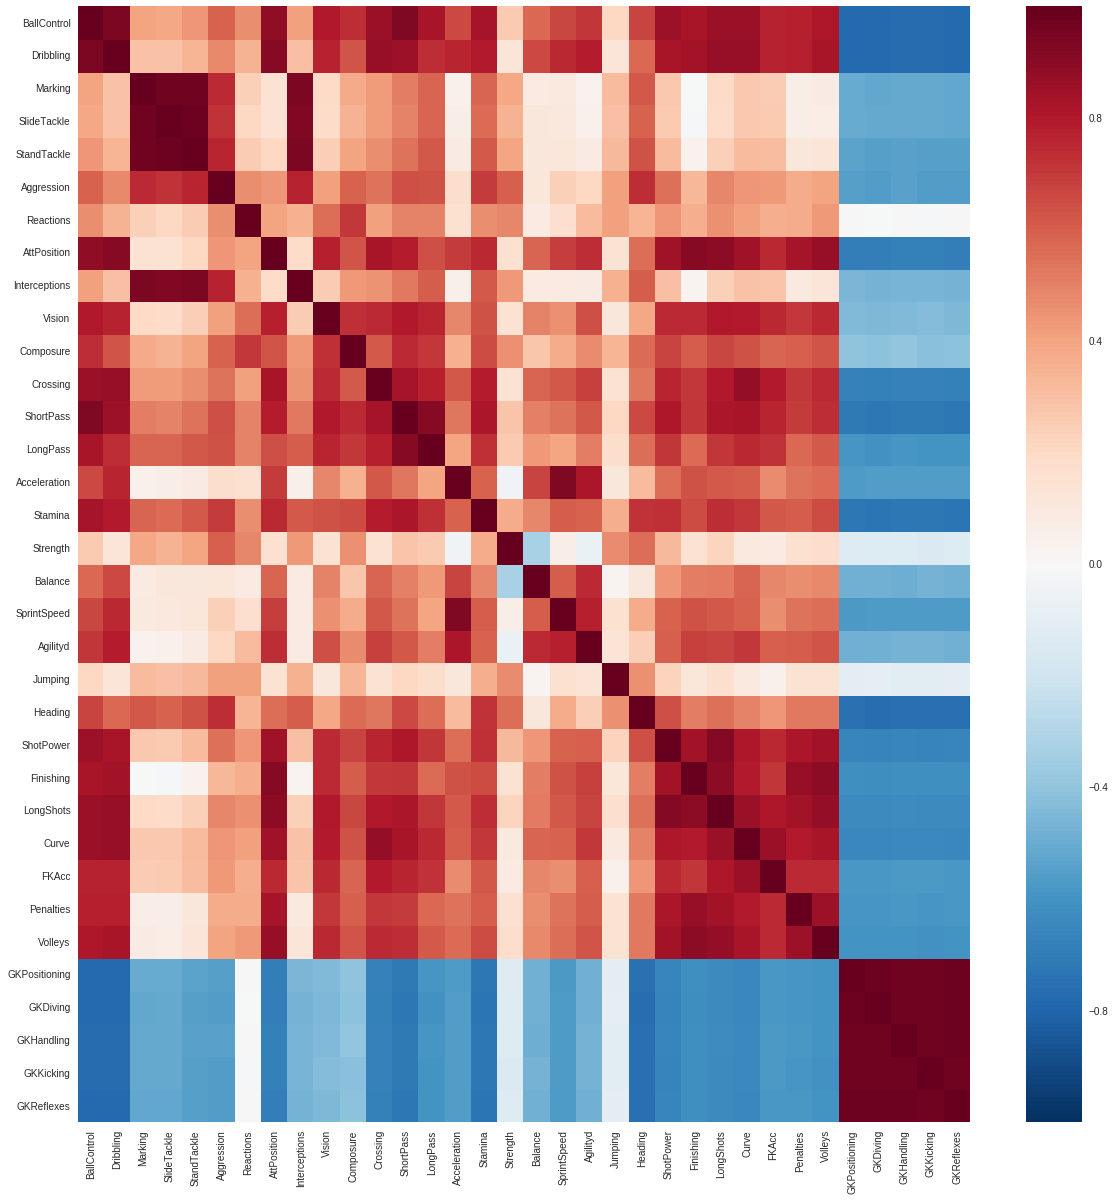

In [19]:
plt.figure(figsize=(20,20))
corr = csv[csv.columns[21:]] .corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show() #Display the correlation plot

In [22]:
csv.to_csv('FIFIndex_BPL_players_featured.csv', index=True, header=list(csv.dtypes.index), mode='w')

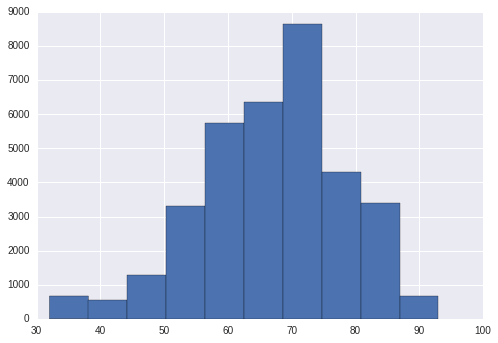

In [24]:
plt.hist(csv.Jumping.tolist())
plt.show()

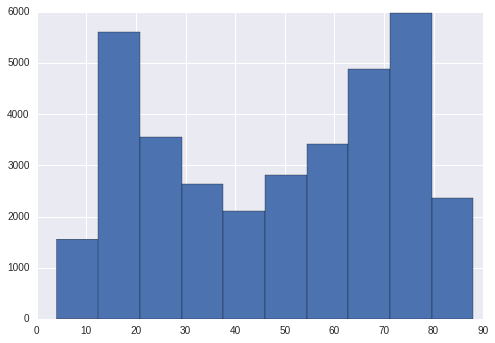

In [26]:
plt.hist(csv.Marking.tolist())
plt.show()

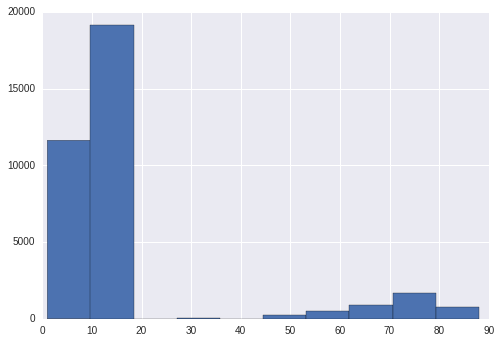

In [27]:
plt.hist(csv.GKDiving.tolist())
plt.show()